# 🌫️ Atmospheric CO₂ Data Cleaning & Preparation

This notebook processes and enriches the **Mauna Loa daily atmospheric CO₂ dataset** from NOAA and Scripps. The goal is to prepare the data for visualization in Tableau and deeper analysis.

---

## 🧹 Data Cleaning Objectives

- Load the raw daily CO₂ data from the NOAA `.txt` file
- Parse and format the date fields correctly
- Remove flagged or invalid entries (e.g., `-99.99` values)
- Handle missing values using appropriate techniques (e.g., interpolation, rolling averages)
- Standardize column names for clarity

---

## 🧪 Feature Engineering Plan

We’ll create a variety of new features to support time-series analysis and storytelling:

| Feature | Description |
|--------|-------------|
| `date`, `year`, `month`, `day`, `day_of_year` | Temporal breakdown |
| `co2_30d_avg`, `co2_365d_avg` | Rolling averages to smooth trends |
| `daily_diff`, `monthly_diff`, `pct_change` | Growth and rate-of-change metrics |
| `anomaly_flag` | Outlier detection based on z-scores or thresholds |
| `sin_day`, `cos_day` | Cyclical encodings for seasonality and radial plots |
| `season` | Categorical: Winter, Spring, Summer, Fall |
| `forecast` | Modeled prediction of future CO₂ levels |

---

## 📦 Output Files

- `co2_with_features.csv` – Cleaned + engineered features for visualization

---

## 🛠️ Tools Used

- `pandas` – Data manipulation
- `numpy` – Numerical operations
- `matplotlib / seaborn` – Data exploration
- `datetime` – Date parsing and manipulation
- `scipy` – Anomaly detection / z-score
- `Prophet` - Forecasting
---

In [1]:
# 📦 Import standard libraries
import pandas as pd
import numpy as np
from io import StringIO
import requests
import os
from scipy.stats import zscore
from prophet import Prophet

# 📊 (Optional) For quick visual checks
import matplotlib.pyplot as plt
import seaborn as sns

# 📁 For handling Excel files (if needed)
import openpyxl  # required for reading .xlsx files with pd.read_excel()

# 🔧 Display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)


In [2]:
# It was quicker to clean up the data in Excel, so we'll skip through any cleaning and load in the csv into df
df = pd.read_csv('../data/co2_daily_cleaned.csv', names = ["year", "month", "day", "decimal", "co2_molfrac"])


In [3]:
# Make a datetime column

df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


In [4]:
# Create day_of_year column

df['day_of_year'] = df['date'].dt.dayofyear


In [5]:
# Setting index to datetime column to calculate 30d/365d rolling averages for co2

df.set_index('date', inplace=True)


In [6]:
# Add rolling 30d/365d rolling averages for co2

df['co2_30d_avg'] = df["co2_molfrac"].rolling(window='30D').mean().round(2)
df['co2_365_avg'] = df["co2_molfrac"].rolling(window='365D').mean().round(2)


In [7]:
# Add daily differences

df['daily_diff'] = df['co2_molfrac'].diff()


In [8]:
# Create df of monthly differences

monthly = df.resample('M').mean(numeric_only=True).round(2)
monthly['monthly_diff'] = monthly['co2_molfrac'].diff()


In [9]:
# Create daily, and monthly, percentage change

df['pct_change'] = df['co2_molfrac'].pct_change() * 100
monthly['pct_change'] = monthly['co2_molfrac'].pct_change() * 100


In [10]:
# z-score calculation setup for anomaly detection

df['z-score'] = zscore(df['co2_molfrac'])


In [11]:
# Flag anomalies where z-score > 2

df['anomaly_flag'] = (df['z-score']).abs() > 2


In [12]:
# polar coordinates so we can create seasonal/radial plots

df['sin_day'] = np.sin((2*np.pi*df['day_of_year'])/365) # y value
df['cos_day'] = np.cos((2*np.pi*df['day_of_year'])/365) # x value

In [13]:
# Categorize dates by season
# We'll use meteorlogical seasons since they are a little bit easier to work with

def set_season(month):
    
    if (month == 12 or month == 1 or month == 2):
        return "Winter"
    elif (month == 3 or month == 4 or month == 5):
        return "Spring"
    elif (month == 6 or month == 7 or month == 8):
        return "Summer"
    else:
        return "Autumn"

df['season'] = df.index.to_series().dt.month.apply(set_season)


In [49]:
# co2 forecasting

df_prophet = pd.DataFrame({
    'ds': df.index,
    'y': df['co2_molfrac'].values
})

model = Prophet(yearly_seasonality=True)
model.fit(df_prophet)

# Create future dates (e.g., next 10 years = 120 months)
future = model.make_future_dataframe(periods=120, freq='M')

# Predict future values
forecast = model.predict(future)

15:03:43 - cmdstanpy - INFO - Chain [1] start processing
15:03:50 - cmdstanpy - INFO - Chain [1] done processing


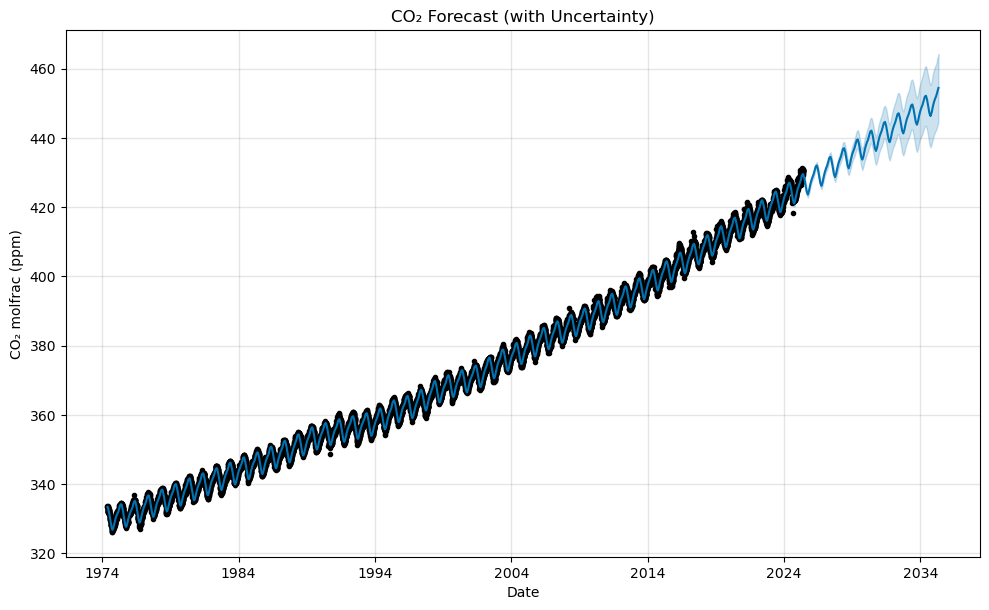

In [50]:
# plotting
model.plot(forecast)
plt.title("CO₂ Forecast (with Uncertainty)")
plt.xlabel("Date")
plt.ylabel("CO₂ molfrac (ppm)")
plt.show()

In [59]:
# Filter out dates so we only have forecasted data
last_date = df_prophet['ds'].max()
forecast_future = forecast[forecast['ds'] > last_date]

In [60]:
# Set index to date
forecast_future = forecast_future.set_index('ds')

In [62]:
# Saving the dataframes we created
monthly.to_csv('../data/monthly_features.csv', index=True)
df.to_csv('../data/features.csv', index=True)
forecast_future.to_csv('../data/forecast_future.csv', index=True)